In [3]:
import pandas as pd 
import numpy as np
import os 
import scipy.stats as stats
import seaborn as sns 
import matplotlib.pyplot as plt 

## Set input and output folders 

In [4]:
# analysis folder version  
analysis_version = '007'


In [5]:
out_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis',
                        analysis_version, 
                        '003_scatter_video_vs_outcomes_test_log')

if not os.path.exists(out_path): 
    os.makedirs(out_path)

print(out_path)

C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis\007\003_scatter_video_vs_outcomes_test_log


### Load Clean Data - no missing BW Data 
May be missing video data - see excel with counts 

In [6]:
# PWS 
zv_pws_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                    analysis_version, 
                                    '000_merged_cleaned_data\zv_bw_merged_gait_vertical_PWS_1_clean.csv')
zv_pws_bw_clean_df = pd.read_csv(zv_pws_bw_clean_path, index_col = 0)

# FW 
zv_fw_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                    analysis_version, 
                                   '000_merged_cleaned_data\zv_bw_merged_gait_vertical_FW_1_clean.csv') 
zv_fw_bw_clean_df = pd.read_csv(zv_fw_bw_clean_path, index_col = 0) 

# Home Videos 
hv_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                analysis_version, 
                                '000_merged_cleaned_data\hv_bw_merged_clean.csv') 

hv_bw_clean_df = pd.read_csv(hv_bw_clean_path, index_col = 0) 

In [7]:
hv_bw_clean_df.columns

Index(['video_id_date_name_pose_hv', 'id_date_pose_hv', 'task_pose_hv',
       'frames_per_second_pose_hv', 'total_video_duration_sec_pose_hv',
       'delta_pix_h_rel_median_pose_hv', 'walking_segmets_n_pose_hv',
       'walking_segments_duration_mean_pose_hv',
       'walking_segments_duration_median_pose_hv',
       'stride_time_mean_sec_pose_hv',
       ...
       'EDSS_same_before_after_MM', 'demoEHR_Vitals_dateDiff',
       'tc_Examinee_Education', 'edss_severity_num', 'edss_severity_cat',
       't25fw_group_num', 't25fw_group_cat', 'race_ethnicity_clean',
       'ms_dx_condensed', 'bw_hv_date_diff_days'],
      dtype='object', length=126)

## Review outcomes and transform home videos

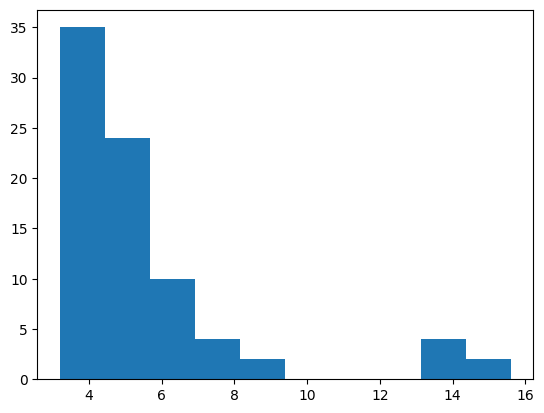

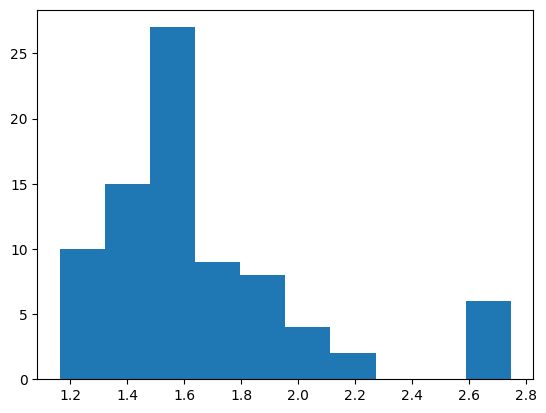

In [28]:
# home videos T25FW 
plt.hist(hv_bw_clean_df['clean_T25FW_Avg'])
plt.show()
plt.close()

# log transform T25FW 
hv_bw_clean_df['log_T25FW'] = np.log(hv_bw_clean_df['clean_T25FW_Avg'])
plt.hist(hv_bw_clean_df['log_T25FW'])
plt.show()
plt.close()

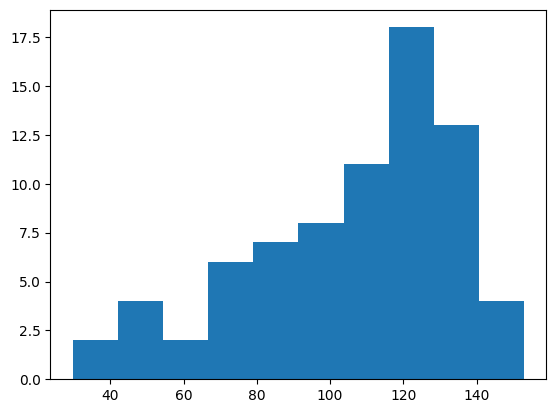

In [9]:
# pws at most recent visit 
plt.hist(hv_bw_clean_df['PWS_velocitycmsecmean'])
plt.show()
plt.close()

In [10]:
# 

## Scatter plot, correlation, heatmat 
- scatter of each video metric vs: EDSS |  T25FW | Zeno PWS Velocity | Zeno FW Velocity
- heatmap
- .csv file of correlation matrix 

In [11]:
# correlation with clinical outcomes 
def video_vs_outcome_scatter(df, output_folder_path, subfolder_name, color_col): 
    
    out_plots_path = os.path.join(output_folder_path,  subfolder_name + ' scatterplots')
    
    if not os.path.exists(out_plots_path):
        os.makedirs(out_plots_path)

    if not os.path.exists(os.path.join(out_plots_path, 'edss')):
        os.makedirs(os.path.join(out_plots_path, 'edss'))

    if not os.path.exists(os.path.join(out_plots_path, 't25fw')):
        os.makedirs(os.path.join(out_plots_path, 't25fw'))

 #   if not os.path.exists(os.path.join(out_plots_path, 't25fw_log')):
     #   os.makedirs(os.path.join(out_plots_path, 't25fw_log'))

    if not os.path.exists(os.path.join(out_plots_path, 'PWS_velocity')):
        os.makedirs(os.path.join(out_plots_path, 'PWS_velocity'))

    if not os.path.exists(os.path.join(out_plots_path, 'FW_velocity')):
        os.makedirs(os.path.join(out_plots_path, 'FW_velocity'))
        

    # drop date time columns 
    if 'bw_hv_abs_date_diff' in df.columns:
        df = df.drop(columns=['bw_hv_abs_date_diff'])
 
    # Keep only numeric and ordinal columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    ordinal_cols = df.select_dtypes(include=['category']).columns
    df_num = df[numeric_cols.union(ordinal_cols)]

    # Create an empty DataFrame to store the Spearman correlation coefficients
    n_cols = df_num.shape[1]

    corr_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), columns=df_num.columns, index=df_num.columns)
    pvalue_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), columns=df_num.columns, index=df_num.columns)
    n_videos_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), columns=df_num.columns, index=df_num.columns)
    
    for col1 in df_num.columns:
        for col2 in df_num.columns:

            df_num_clean = df.dropna(subset=[col1, col2]) # drop rows if col1 and col2 are both nan

            # unless all values the same in one column, run spearman correlation
            if df_num_clean[col1].nunique() <= 1 or df_num_clean[col2].nunique() <= 1: 
                corr = np.nan
                p_value = np.nan 
            else: 
                corr, p_value = stats.spearmanr(df_num_clean[col1], df_num_clean[col2])

            # save results in matrix 
            corr_matrix.loc[col1, col2] = round(corr, 2)
            pvalue_matrix.loc[col1, col2] = round(p_value, 3)
            n_videos_matrix.loc[col1, col2] = len(df_num_clean) # number of rows with data for both columns 

            # scatterplot of EDSS, T25FW, and mat velocity 
            if col1 == 'clean_EDSS':
                sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col) 
                plt.title(subfolder_name)
                plt.savefig(os.path.join(out_plots_path, 'edss', col2 + '.png'))
                plt.close()

            if col1 == 'clean_T25FW_Avg':
                sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col) 
                plt.title(subfolder_name)
                plt.savefig(os.path.join(out_plots_path, 't25fw', col2 + '.png'))
                plt.close()

      #      if col1 == 'log_T25FW':
     #            sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col) 
      #           plt.title(subfolder_name)
     #            plt.savefig(os.path.join(out_plots_path, 't25fw_log', col2 + '.png'))
      #           plt.close()

            if col1 == 'PWS_velocitycmsecmean': 
                sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col)
                plt.title(subfolder_name)
                plt.savefig(os.path.join(out_plots_path, 'PWS_velocity', col2 + '.png'))
                plt.close()

            if col1 == 'FW_velocitycmsecmean': 
                sns.scatterplot(data=df_num_clean, x=col2, y=col1, hue = color_col) 
                plt.title(subfolder_name)
                plt.savefig(os.path.join(out_plots_path, 'FW_velocity', col2 + '.png'))
                plt.close()
                
    # save correlation matrix - full 
    corr_matrix.to_csv(os.path.join(output_folder_path, subfolder_name + '_corr_matrix.csv'))
    pvalue_matrix.to_csv(os.path.join(output_folder_path, subfolder_name + '_pvalue_matrix.csv'))
    n_videos_matrix.to_csv(os.path.join(output_folder_path, subfolder_name + '_n_pairs_matrix.csv'))

                
    # Keep specific values from corr_matrix and p-val matrix for heat map 
    outcomes_to_plot = ['clean_EDSS', 
                        'clean_T25FW_Avg',
                 #        'log_T25FW',
                         'PWS_velocitycmsecmean']
                         #'FW_velocitycmsecmean']

    metrics_to_plot = ['delta_pix_h_rel_median_pose',
                       'stride_time_median_sec_pose',
                       'mean_cadence_step_per_min_pose',
                       'stride_width_median_cm_pose',
                     #  'stance_time_per_mean_pose',
                       'singlesupport_per_mean_pose', 
                       'tot_dsupport_per_mean_pose'
                       ]

    metrics_joined = '|'.join(metrics_to_plot)

    corr_matrix_filt = corr_matrix.loc[corr_matrix.index.isin(outcomes_to_plot), corr_matrix.columns.str.contains(metrics_joined)]

    # if home videos df, clean column and index labels for plotting 
    # in person video is zv 
    if 'delta_pix_h_rel_median_pose_hv' in corr_matrix_filt.columns:
        corr_matrix_filt = corr_matrix_filt.rename(columns = {'delta_pix_h_rel_median_pose_hv' : 'Change in Pixel Height', 
                                                              'stride_time_median_sec_pose_hv' : 'Stride Time', 
                                                              'mean_cadence_step_per_min_pose_hv' : 'Cadence', 
                                                              'stride_width_median_cm_pose_hv' : 'Stride Width', 
                                                              'tot_dsupport_per_mean_pose_hv' : 'Double Support %',
                                                              'singlesupport_per_mean_pose_hv' : 'Single Support %',
                                                              'clean_T25FW_Avg' : 'T25FW (seconds)', 
                                                              'PWS_velocitycmsecmean' : 'PWS Velocity (cm/second)', 
                                                              'clean_EDSS' : 'EDSS'}, 
                                                  index = {'delta_pix_h_rel_median_pose_hv' : 'Change in Pixel Height', 
                                                              'stride_time_median_sec_pose_hv' : 'Stride Time', 
                                                              'mean_cadence_step_per_min_pose_hv' : 'Cadence', 
                                                              'stride_width_median_cm_pose_hv' : 'Stride Width', 
                                                              'tot_dsupport_per_mean_pose_hv' : 'Double Support %', 
                                                              'singlesupport_per_mean_pose_hv' : 'Single Support %',
                                                              'clean_T25FW_Avg' : 'T25FW (seconds)', 
                                                              'PWS_velocitycmsecmean' : 'PWS Velocity (cm/second)', 
                                                              'clean_EDSS' : 'EDSS'}) 

    #  Plot and save the heatmap 
    plt.figure(figsize=(4, 2))
    sns.heatmap(corr_matrix_filt, annot=True, fmt=".2f", cmap="coolwarm", center=0, annot_kws={"fontsize": 7}, cbar_kws={"shrink": 0.8})
    plt.title(f"Spearman Correlation Heatmap: {subfolder_name}", fontsize = 9, fontweight = 'bold')
    plt.xticks(fontsize=7, fontstyle = 'italic')
    plt.yticks(fontsize=7, fontstyle = 'italic')
    plt.savefig(os.path.join(output_folder_path, subfolder_name + '_heatmap.png'), bbox_inches = 'tight')
    plt.show()
    plt.close()



# Plot each numeric columns vs EDSS, T25FW, PWS and FW velocity 
Color by one column 

In [17]:
# PWS 
zv_pws_bw_clean_df_2 = zv_pws_bw_clean_df.dropna(subset = ['delta_pix_h_rel_median_pose_zv',
                                                   'stride_time_median_sec_pose_zv', 
                                                   'mean_cadence_step_per_min_pose_zv', 
                                                   'stride_width_median_cm_pose_zv'])
zv_pws_bw_clean_df_2 = zv_pws_bw_clean_df_2.copy()

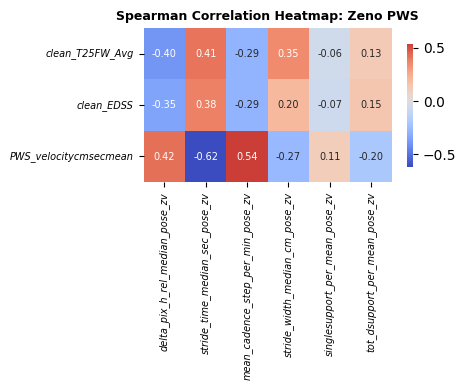

In [8]:
# PWS 
# color dots by how fast person is walking in video metrics were derived from 
video_vs_outcome_scatter(df = zv_pws_bw_clean_df_2, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Zeno PWS',
                         color_col = 'PWS_velocitycmsecmean')

In [9]:
# FW clean 
zv_fw_bw_clean_df_2 = zv_fw_bw_clean_df.dropna(subset = ['delta_pix_h_rel_median_pose_zv',
                                                   'stride_time_median_sec_pose_zv', 
                                                   'mean_cadence_step_per_min_pose_zv', 
                                                   'stride_width_median_cm_pose_zv'])
zv_fw_bw_clean_df_2 = zv_fw_bw_clean_df_2.copy()

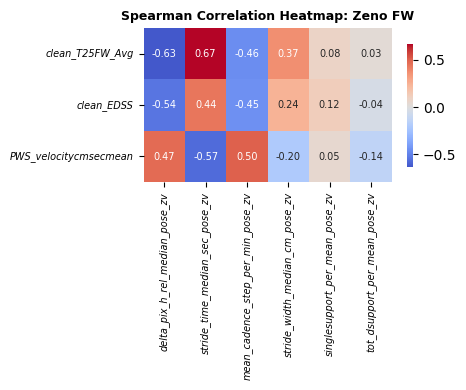

In [10]:
# FW 
# color dots by how fast person is walking in video metrics were derived from 
video_vs_outcome_scatter(df = zv_fw_bw_clean_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Zeno FW', 
                        color_col = 'FW_velocitycmsecmean')

## home select specific cols and rows 
only use subset of columns to run analysis faster 

In [31]:
# video metrics to average 
hv_colnames = ['delta_pix_h_rel_median_pose_hv',
               'stride_time_median_sec_pose_hv', 
               'mean_cadence_step_per_min_pose_hv',
               'stride_width_median_cm_pose_hv',
               'singlesupport_per_mean_pose_hv',
               'tot_dsupport_per_mean_pose_hv']

bw_colnames = ['clean_T25FW_Avg', 
                'log_T25FW', 
               'PWS_velocitycmsecmean', 'clean_EDSS', 
              'PWS_cadencestepsminmean', 'PWS_singlesupportmean', 'PWS_stridetimesecmean', 
               'PWS_stridewidthcmmean',	'PWS_totaldsupportmean']


hv_bw_colnames = hv_colnames + bw_colnames + ['bw_id', 'task_pose_hv', 'video_id_date_name_pose_hv', 'id_date_pose_hv', 'bw_hv_date_diff_days']
hv_bw_colnames

['delta_pix_h_rel_median_pose_hv',
 'stride_time_median_sec_pose_hv',
 'mean_cadence_step_per_min_pose_hv',
 'stride_width_median_cm_pose_hv',
 'singlesupport_per_mean_pose_hv',
 'tot_dsupport_per_mean_pose_hv',
 'clean_T25FW_Avg',
 'log_T25FW',
 'PWS_velocitycmsecmean',
 'clean_EDSS',
 'PWS_cadencestepsminmean',
 'PWS_singlesupportmean',
 'PWS_stridetimesecmean',
 'PWS_stridewidthcmmean',
 'PWS_totaldsupportmean',
 'bw_id',
 'task_pose_hv',
 'video_id_date_name_pose_hv',
 'id_date_pose_hv',
 'bw_hv_date_diff_days']

In [32]:
hv_bw_clean_df_simple = hv_bw_clean_df[hv_bw_colnames]
hv_bw_clean_df_simple.head()    

,delta_pix_h_rel_median_pose_hv,stride_time_median_sec_pose_hv,mean_cadence_step_per_min_pose_hv,stride_width_median_cm_pose_hv,singlesupport_per_mean_pose_hv,tot_dsupport_per_mean_pose_hv,clean_T25FW_Avg,log_T25FW,PWS_velocitycmsecmean,clean_EDSS,PWS_cadencestepsminmean,PWS_singlesupportmean,PWS_stridetimesecmean,PWS_stridewidthcmmean,PWS_totaldsupportmean,bw_id,task_pose_hv,video_id_date_name_pose_hv,id_date_pose_hv,bw_hv_date_diff_days
0,0.22,1.133,107.160,11.820,22.50,45.00,3.6,1.280934,136.683,3.0,116.129,34.807,1.028,8.185,30.295,BW-0018,gait_vertical_left,gait_vertical_left_BW-0018_10-24-23,BW-0018\10-24-23,0
1,0.31,1.100,93.266,12.354,30.40,39.08,3.6,1.280934,136.683,3.0,116.129,34.807,1.028,8.185,30.295,BW-0018,gait_vertical_right,gait_vertical_right_BW-0018_10-24-23,BW-0018\10-24-23,0
2,0.43,1.033,111.840,11.127,32.73,31.31,3.4,1.223775,115.829,3.5,111.917,35.801,1.065,8.330,28.473,BW-0023,gait_vertical_left,gait_vertical_left_BW-0023_05-05-23,BW-0023\05-05-23,9
3,0.39,1.067,104.894,11.211,36.65,25.85,3.4,1.223775,115.829,3.5,111.917,35.801,1.065,8.330,28.473,BW-0023,gait_vertical_right,gait_vertical_right_BW-0023_05-05-23,BW-0023\05-05-23,9
4,0.30,1.000,103.888,9.131,29.96,38.26,4.4,1.481605,139.984,3.0,127.434,36.945,0.945,8.688,26.061,BW-0023,gait_vertical_left,gait_vertical_left_BW-0023_10-23-23,BW-0023\10-23-23,0


## Home all Videos 

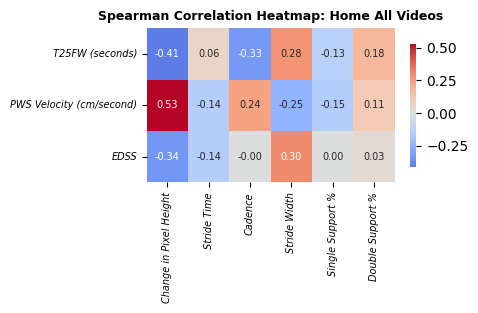

In [40]:
video_vs_outcome_scatter(df = hv_bw_clean_df_simple, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home All Videos',
                         color_col = 'bw_hv_date_diff_days')

## Home videos - filter to only include videos with all metrics metrics 
without all metrics, poorer quality video?

In [14]:
hv_bw_clean_df_2 = hv_bw_clean_df_simple.dropna(subset = ['delta_pix_h_rel_median_pose_hv',
                                                   'stride_time_median_sec_pose_hv', 
                                                   'mean_cadence_step_per_min_pose_hv', 
                                                   'stride_width_median_cm_pose_hv'])
hv_bw_clean_df_2 = hv_bw_clean_df_simple.copy()

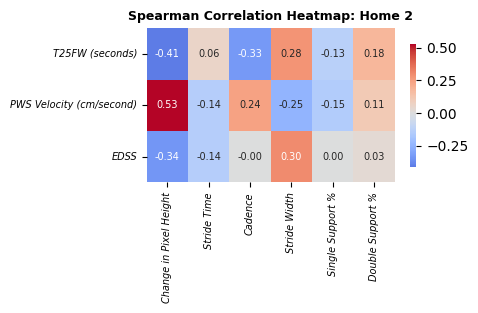

In [15]:
# Home Videos  
# color dots by most recent preferred walking speed task 
video_vs_outcome_scatter(df = hv_bw_clean_df_2, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home 2',
                         color_col = 'bw_hv_date_diff_days')

In [16]:
# clean - right_2 --> right and same for left 
hv_bw_clean_df_2['task_pose_hv'] = hv_bw_clean_df_2['task_pose_hv'].replace('gait_vertical_left_2', 'gait_vertical_left')
hv_bw_clean_df_2['task_pose_hv'] = hv_bw_clean_df_2['task_pose_hv'].replace('gait_vertical_right_2', 'gait_vertical_right')
hv_bw_clean_df_2['task_pose_hv'].value_counts()

task_pose_hv
gait_vertical_right    41
gait_vertical_left     40
Name: count, dtype: int64

## Home videos only right turning 

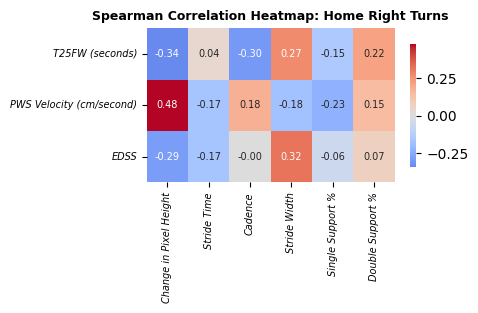

In [17]:
# Home Right 
hv_bw_clean_df_2_right = hv_bw_clean_df_2.loc[hv_bw_clean_df_2['task_pose_hv'] == 'gait_vertical_right']
hv_bw_clean_df_2_right['task_pose_hv'].value_counts()

video_vs_outcome_scatter(df = hv_bw_clean_df_2_right, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Right Turns', 
                        color_col = 'PWS_velocitycmsecmean')

## Home videos only left turning  

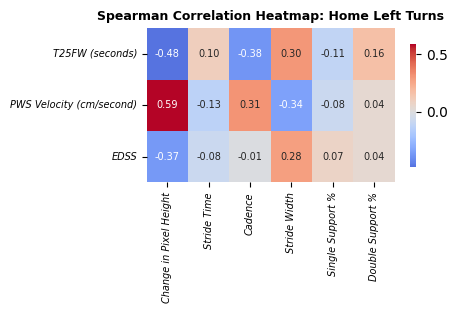

In [18]:
# Home Left 
hv_bw_clean_df_2_left = hv_bw_clean_df_2.loc[hv_bw_clean_df_2['task_pose_hv'] == 'gait_vertical_left']
hv_bw_clean_df_2_left['task_pose_hv'].value_counts()

video_vs_outcome_scatter(df = hv_bw_clean_df_2_left, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home Left Turns', 
                         color_col = 'PWS_velocitycmsecmean')

## Home Videos - mean of right and left video 

In [33]:
# 1 video per participant 
# only videos with n walking segments >0
# if left and right vidoe with walking segment n 0 --> mean of left and right 
# if either just left or right, exclude 

# group by visit id (date and bw_ID), then average right and left if both are present 
averaged_home_df = (
    hv_bw_clean_df_simple
    .groupby('id_date_pose_hv')[hv_colnames]
    .mean()
    .reset_index()
)

task_counts = hv_bw_clean_df_simple.groupby('id_date_pose_hv')['task_pose_hv'].nunique().reset_index(name='task_count')

# Merge if you want to keep track of which rows were single-task vs dual-task
result_df = averaged_home_df.merge(task_counts, on='id_date_pose_hv')
result_df

# Merge average with Zeno data
bw_mat_cols = bw_colnames
bw_mat_cols.append('id_date_pose_hv') 
bw_mat_df = hv_bw_clean_df[bw_mat_cols] # select PWS columns and id_date_pose_hv
bw_mat_df = bw_mat_df.drop_duplicates(subset=['id_date_pose_hv'], keep='last')
averaged_home_w_bw_df = result_df.merge(bw_mat_df, on = 'id_date_pose_hv')

In [34]:
averaged_home_w_bw_df.head()

,id_date_pose_hv,delta_pix_h_rel_median_pose_hv,stride_time_median_sec_pose_hv,mean_cadence_step_per_min_pose_hv,stride_width_median_cm_pose_hv,singlesupport_per_mean_pose_hv,tot_dsupport_per_mean_pose_hv,task_count,clean_T25FW_Avg,log_T25FW,PWS_velocitycmsecmean,clean_EDSS,PWS_cadencestepsminmean,PWS_singlesupportmean,PWS_stridetimesecmean,PWS_stridewidthcmmean,PWS_totaldsupportmean
0,BW-0004\03-11-2025,0.395,1.2500,93.3305,10.4850,29.185,37.960,2,4.4,1.481605,NaN,2.0,NaN,NaN,NaN,NaN,NaN
1,BW-0018\10-24-23,0.265,1.1165,100.2130,12.0870,26.450,42.040,2,3.6,1.280934,136.683,3.0,116.129,34.807,1.028,8.185,30.295
2,BW-0023\05-05-23,0.410,1.0500,108.3670,11.1690,34.690,28.580,2,3.4,1.223775,115.829,3.5,111.917,35.801,1.065,8.330,28.473
3,BW-0023\10-23-23,0.345,0.9915,111.5700,11.0225,29.960,38.260,2,4.4,1.481605,139.984,3.0,127.434,36.945,0.945,8.688,26.061
4,BW-0025\11-28-2023,0.210,1.0835,105.8525,14.1730,36.640,27.085,2,4.4,1.481605,96.550,4.5,113.966,33.974,1.047,13.049,32.135


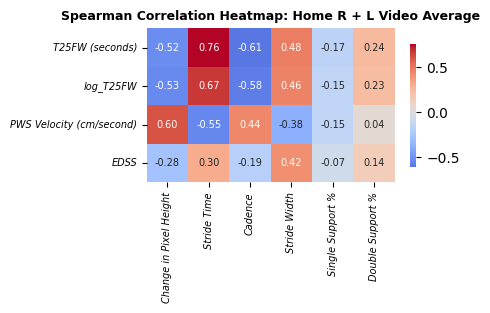

In [20]:
video_vs_outcome_scatter(df = averaged_home_w_bw_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home R + L Video Average', 
                         color_col = 'PWS_velocitycmsecmean')

## Remove slowest walkers 

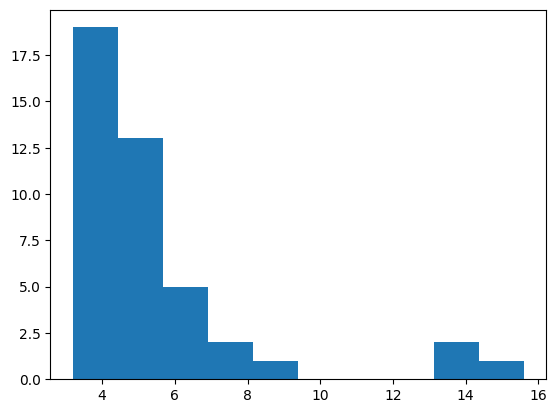

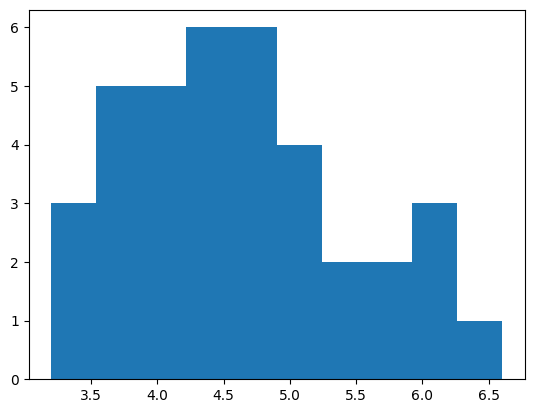

In [40]:
plt.hist(averaged_home_w_bw_df['clean_T25FW_Avg'])
plt.show()
plt.close()


fast_av_home_w_bw_df = averaged_home_w_bw_df.loc[averaged_home_w_bw_df['clean_T25FW_Avg'] < 8]
plt.hist(fast_av_home_w_bw_df['clean_T25FW_Avg'])
plt.show()
plt.close()

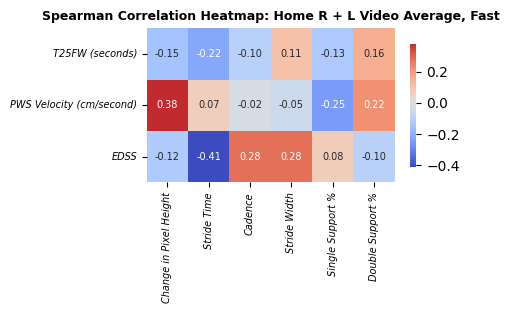

In [19]:
video_vs_outcome_scatter(df = fast_av_home_w_bw_df, 
                         output_folder_path = out_path, 
                         subfolder_name = 'Home R + L Video Average, Fast', 
                         color_col = 'PWS_velocitycmsecmean')

ShapiroResult(statistic=0.9825031966512291, pvalue=0.8152769654011452)

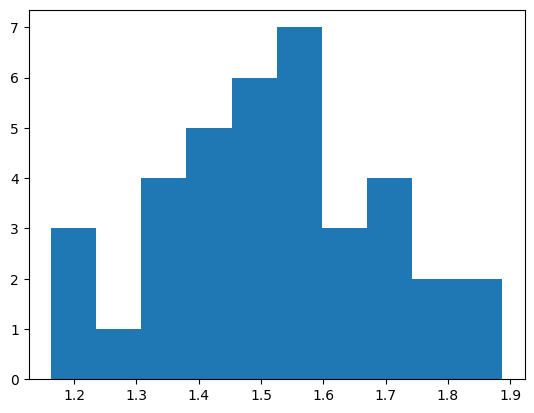

In [45]:
plt.hist(fast_av_home_w_bw_df['log_T25FW'])
stats.shapiro(fast_av_home_w_bw_df['log_T25FW'], nan_policy = 'omit')

## Transform home videos and outputs - Pearson?? 

ShapiroResult(statistic=0.828475971649212, pvalue=1.567046257485712e-05)

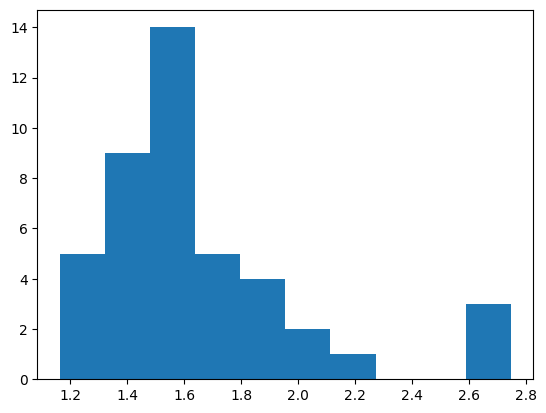

In [41]:
plt.hist(averaged_home_w_bw_df['log_T25FW'])
stats.shapiro(averaged_home_w_bw_df['log_T25FW'], nan_policy = 'omit')

ShapiroResult(statistic=0.9524550048514594, pvalue=0.09213213730459716)

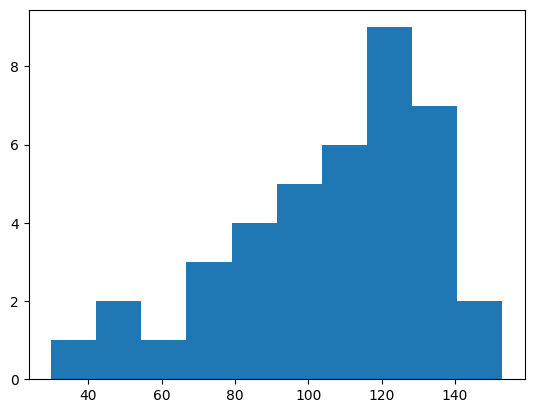

In [33]:
plt.hist(averaged_home_w_bw_df['PWS_velocitycmsecmean'])
stats.shapiro(averaged_home_w_bw_df['PWS_velocitycmsecmean'], nan_policy = 'omit')

ShapiroResult(statistic=0.98604392277332, pvalue=0.8802018815765316)

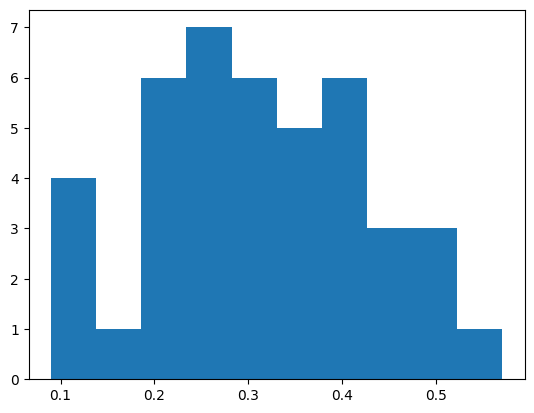

In [35]:
plt.hist(averaged_home_w_bw_df['delta_pix_h_rel_median_pose_hv'])
stats.shapiro(averaged_home_w_bw_df['delta_pix_h_rel_median_pose_hv'], nan_policy = 'omit')

ShapiroResult(statistic=0.8403585158681639, pvalue=4.3793251049254064e-05)

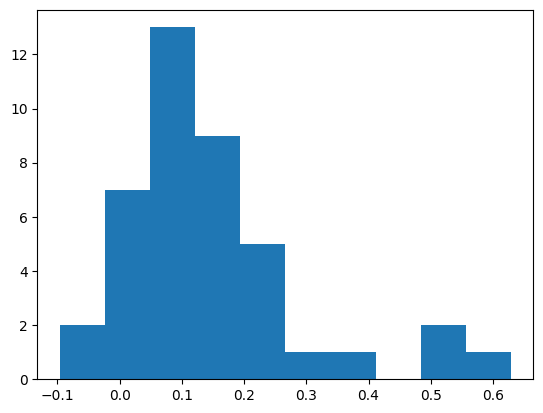

In [21]:
plt.hist(averaged_home_w_bw_df['stride_time_median_sec_pose_hv'])
stats.shapiro(averaged_home_w_bw_df['stride_time_median_sec_pose_hv'], nan_policy = 'omit')
plt.close()

ShapiroResult(statistic=0.8403585158681639, pvalue=4.3793251049254064e-05)

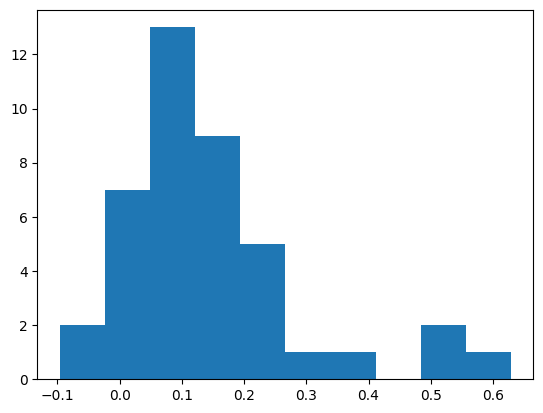

In [22]:
plt.hist(np.log(averaged_home_w_bw_df['stride_time_median_sec_pose_hv']))
stats.shapiro(np.log(averaged_home_w_bw_df['stride_time_median_sec_pose_hv']), nan_policy = 'omit')

(array([ 2.,  0.,  1.,  2., 10.,  7., 14.,  2.,  2.,  1.]),
 array([ 60.625  ,  67.93935,  75.2537 ,  82.56805,  89.8824 ,  97.19675,
        104.5111 , 111.82545, 119.1398 , 126.45415, 133.7685 ]),
 <BarContainer object of 10 artists>)

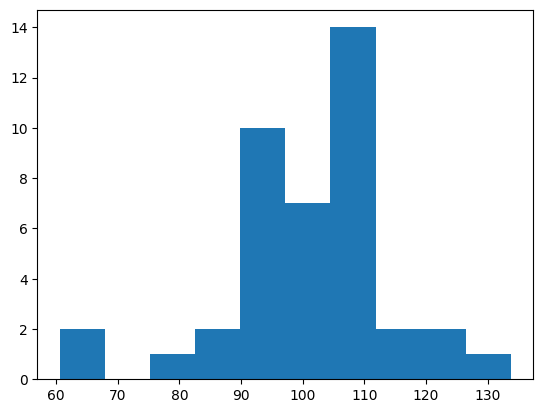

In [25]:
plt.hist(averaged_home_w_bw_df['mean_cadence_step_per_min_pose_hv'])

In [26]:
plt.scatter(np.log(averaged_home_w_bw_df['stride_time_median_sec_pose_hv']), 

            
            averaged_home_w_bw_df['log_T25FW'])

KeyError: 'log_T25FW'